In [6]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

In [7]:
file = open('spambase/spambase.names')
lines = file.readlines()
cols = []
for line in lines:
    if line[0] not in ('|', '\n'):
        if line[0] != "1":
            cols.append(line.split(':')[0])
cols.append('spam')
df = pd.read_csv('spambase/spambase.data', names=cols)
df.fillna(0)
df.head()
X = df[cols[:-1]]
y = df[cols[-1]]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3836)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_train_norm = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

## Decision Tree Classifier

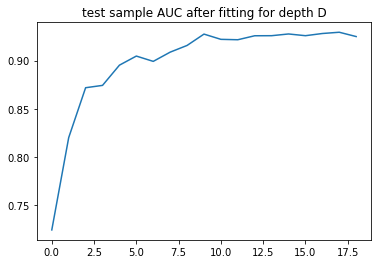

In [9]:
a_test = []
depth = range(1, 20)
for d in depth:
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    fp, tp, _ = roc_curve(y_test, pred)
    roc_auc = auc(fp, tp)
    a_test.append(roc_auc)
plt.plot(a_test)
plt.title('test sample AUC after fitting for depth D')
plt.savefig('tune_dectree_depth.png')

|--- char_freq_$ <= 0.06
|   |--- word_freq_remove <= 0.05
|   |   |--- char_freq_! <= 0.51
|   |   |   |--- word_freq_free <= 0.20
|   |   |   |   |--- word_freq_money <= 0.01
|   |   |   |   |   |--- word_freq_font <= 0.16
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- word_freq_font >  0.16
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- word_freq_money >  0.01
|   |   |   |   |   |--- capital_run_length_average <= 2.25
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- capital_run_length_average >  2.25
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- word_freq_free >  0.20
|   |   |   |   |--- word_freq_our <= 0.05
|   |   |   |   |   |--- char_freq_! <= 0.20
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- char_freq_! >  0.20
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- word_freq_our >  0.05
|   |   |   |   |   |--- word_freq_hpl <= 0.17
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- word_fre

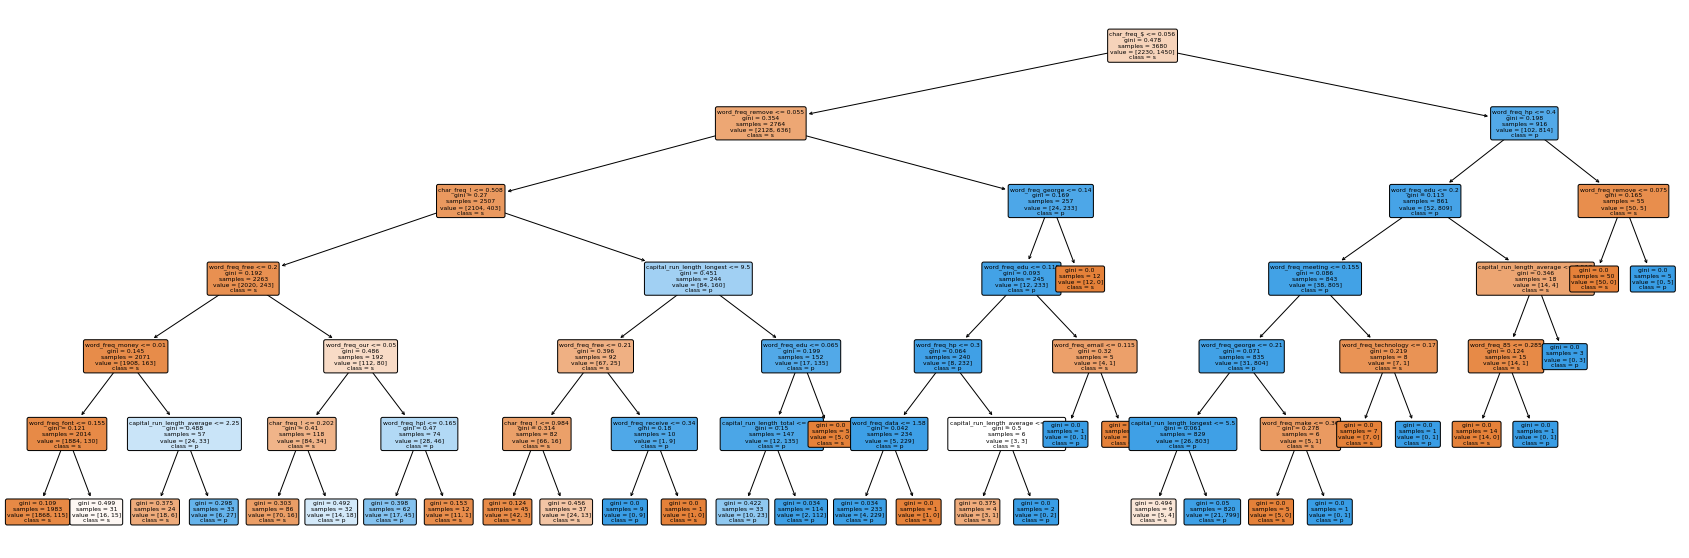

In [10]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)
plt.figure(figsize=(30, 10))
plot_tree(clf, feature_names=cols[:-1], class_names='spam', filled=True, fontsize=6, rounded=True)
plt.savefig('spam_tree.png')
print(export_text(clf, feature_names=cols[:-1]))

In [11]:
pred = clf.predict(X_test)
err_dectree = 1 - accuracy_score(pred, y_test)
err_dectree

0.08686210640608039

## Random Forest Classifier

In [12]:
err_f = []
trees = range(1, 150)
for t in trees:
    clf = RandomForestClassifier(n_estimators=t, max_depth=6)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_train)
    err_f.append(1 - accuracy_score(pred, y_train))
err_dc =  np.ones(len(err_f)) * err_dectree

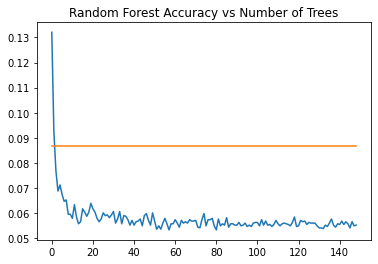

In [13]:
plt.plot(err_f)
plt.plot(err_dc)
plt.title('Random Forest Accuracy vs Number of Trees')
plt.savefig('spam_rf150.png')

In [14]:
err_f

[0.1320652173913044,
 0.09266304347826082,
 0.07690217391304344,
 0.06874999999999998,
 0.071195652173913,
 0.06739130434782614,
 0.06467391304347825,
 0.06521739130434778,
 0.05951086956521734,
 0.05951086956521734,
 0.057880434782608736,
 0.0633152173913043,
 0.05842391304347827,
 0.05570652173913049,
 0.05652173913043479,
 0.0616847826086957,
 0.06032608695652175,
 0.05869565217391304,
 0.06032608695652175,
 0.06385869565217395,
 0.0616847826086957,
 0.06032608695652175,
 0.057880434782608736,
 0.05652173913043479,
 0.05760869565217386,
 0.060054347826086985,
 0.058967391304347805,
 0.05923913043478257,
 0.0581521739130435,
 0.05923913043478257,
 0.06059782608695652,
 0.055978260869565255,
 0.05760869565217386,
 0.06059782608695652,
 0.05570652173913049,
 0.058967391304347805,
 0.05869565217391304,
 0.05733695652173909,
 0.05516304347826084,
 0.057065217391304324,
 0.05516304347826084,
 0.05652173913043479,
 0.056793478260869557,
 0.05760869565217386,
 0.054891304347826075,
 0.05896

## One-class SVM

### Normalized

In [133]:
notspam_idx = y_train.index[y_train==0].values
X_train_notspam = X_train_norm.loc[notspam_idx]
y_train_notspam = y_train.loc[notspam_idx]
spam_proportion = 1 - (len(X_train_notspam))/len(X_train)

svm_median_idx = np.random.choice(np.arange(X_train_norm.shape[0]), size=1000, replace=False)
X_train_norm_median = X_train_norm.iloc[svm_median_idx, :]
distances = pdist(X_train_norm_median, 'sqeuclidean')
m = np.median(distances)
sigma = np.sqrt(m/2)
gamma = 1/(2 * sigma ** 2)

clf = OneClassSVM(kernel='rbf', nu=spam_proportion, gamma=0.000000001)
clf.fit(X_train_notspam)

svm_predict = clf.predict(X_test_norm)

y_test[y_test==0] = -1
1 - accuracy_score(svm_predict, y_test)

0.39413680781758953

### Raw

In [131]:
notspam_idx = y_train.index[y_train==0].values
X_train_notspam = X_train.loc[notspam_idx]
y_train_notspam = y_train.loc[notspam_idx]
spam_proportion = 1 - (len(X_train_notspam))/len(X_train)

svm_median_idx = np.random.choice(np.arange(X_train.shape[0]), size=1000, replace=False)
X_train_median = X_train.iloc[svm_median_idx, :]
distances = pdist(X_train_median, 'sqeuclidean')
m = np.median(distances)
sigma = np.sqrt(m/2)
gamma = 1/(2 * sigma ** 2)

clf = OneClassSVM(kernel='rbf') #,nu=spam_proection, gamma=gammaz)
clf.fit(X_train_notspam)

svm_predict = clf.predict(X_test)

y_test[y_test==0] = -1
1 - accuracy_score(svm_predict, y_test)

0.5439739413680782